# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [14]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [15]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-06-26 06:13:06--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.1’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-06-26 06:13:07 (23.4 MB/s) - ‘airline-passengers.csv.1’ saved [2180/2180]



## Library

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

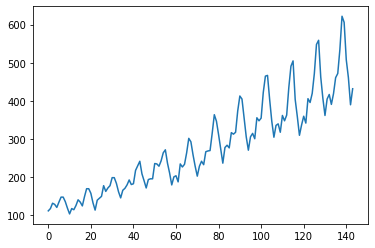

In [17]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [18]:
print(training_set)
print(training_set.reshape(-1))

[[112]
 [118]
 [132]
 [129]
 [121]
 [135]
 [148]
 [148]
 [136]
 [119]
 [104]
 [118]
 [115]
 [126]
 [141]
 [135]
 [125]
 [149]
 [170]
 [170]
 [158]
 [133]
 [114]
 [140]
 [145]
 [150]
 [178]
 [163]
 [172]
 [178]
 [199]
 [199]
 [184]
 [162]
 [146]
 [166]
 [171]
 [180]
 [193]
 [181]
 [183]
 [218]
 [230]
 [242]
 [209]
 [191]
 [172]
 [194]
 [196]
 [196]
 [236]
 [235]
 [229]
 [243]
 [264]
 [272]
 [237]
 [211]
 [180]
 [201]
 [204]
 [188]
 [235]
 [227]
 [234]
 [264]
 [302]
 [293]
 [259]
 [229]
 [203]
 [229]
 [242]
 [233]
 [267]
 [269]
 [270]
 [315]
 [364]
 [347]
 [312]
 [274]
 [237]
 [278]
 [284]
 [277]
 [317]
 [313]
 [318]
 [374]
 [413]
 [405]
 [355]
 [306]
 [271]
 [306]
 [315]
 [301]
 [356]
 [348]
 [355]
 [422]
 [465]
 [467]
 [404]
 [347]
 [305]
 [336]
 [340]
 [318]
 [362]
 [348]
 [363]
 [435]
 [491]
 [505]
 [404]
 [359]
 [310]
 [337]
 [360]
 [342]
 [406]
 [396]
 [420]
 [472]
 [548]
 [559]
 [463]
 [407]
 [362]
 [405]
 [417]
 [391]
 [419]
 [461]
 [472]
 [535]
 [622]
 [606]
 [508]
 [461]
 [390]

## Dataloading

In [19]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 20
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [20]:
print(dataX.size())
print(dataY.size())

torch.Size([123, 20, 1])
torch.Size([123, 1])


In [21]:
print(trainX.size())
print(trainY.size())
print(testX.size())
print(testY.size())

torch.Size([82, 20, 1])
torch.Size([82, 1])
torch.Size([41, 20, 1])
torch.Size([41, 1])


In [22]:
print(dataX[0])

tensor([[0.0154],
        [0.0270],
        [0.0541],
        [0.0483],
        [0.0328],
        [0.0598],
        [0.0849],
        [0.0849],
        [0.0618],
        [0.0290],
        [0.0000],
        [0.0270],
        [0.0212],
        [0.0425],
        [0.0714],
        [0.0598],
        [0.0405],
        [0.0869],
        [0.1274],
        [0.1274]])


## Model

In [23]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [24]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

net = LSTM(num_classes, input_size, hidden_size, num_layers)
inputX = torch.rand(82, 20, 1)
inputY = torch.rand(82, 1)
predic = net(inputX)
print(inputY.size())
print(predic.size())

torch.Size([82, 1])
torch.Size([82, 1])


## Training

In [25]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02603
Epoch: 100, loss: 0.00901
Epoch: 200, loss: 0.00284
Epoch: 300, loss: 0.00237
Epoch: 400, loss: 0.00223
Epoch: 500, loss: 0.00217
Epoch: 600, loss: 0.00211
Epoch: 700, loss: 0.00204
Epoch: 800, loss: 0.00198
Epoch: 900, loss: 0.00191
Epoch: 1000, loss: 0.00186
Epoch: 1100, loss: 0.00179
Epoch: 1200, loss: 0.00172
Epoch: 1300, loss: 0.00167
Epoch: 1400, loss: 0.00163
Epoch: 1500, loss: 0.00160
Epoch: 1600, loss: 0.00155
Epoch: 1700, loss: 0.00150
Epoch: 1800, loss: 0.00145
Epoch: 1900, loss: 0.00141


## Testing for Airplane Passengers Dataset

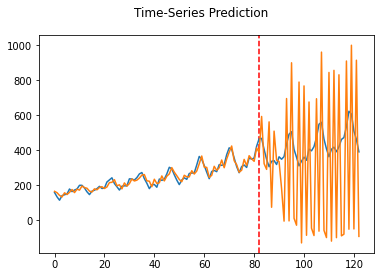

In [26]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [27]:
print(dataX.size())
print(trainX.size())

torch.Size([123, 20, 1])
torch.Size([82, 20, 1])
